아직 ETF 티커를 찾을 수 없음

In [49]:
# https://blog.naver.com/okkam76/221286358499
import datetime as dt

In [50]:
import pandas_datareader.data as web

import pandas as pd
import numpy as np
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [51]:
# !pip install pandas_datareader

In [52]:
import pandas_datareader.data as web

In [53]:
def get_price_from_morningstar(ticker):
    start = dt.datetime(2015,1,1) # 시작날짜
    end = dt.datetime.now() # 현재날짜

    df = web.DataReader(ticker, 'stooq', start, end) # STOOQ API 사용
    # df.reset_index(inplace=True) # index 재설정
    # df.set_index('Date', inplace=True) # 날짜행 인덱스 지정
    # df = df.drop("Symbol", axis=1) # 종목코드행 삭제
    
    return df

In [54]:
get_price_from_morningstar('EWY')

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-31,68.720,68.810,67.990,68.040,4882415
2022-05-27,67.400,67.720,67.300,67.600,2091864
2022-05-26,65.870,66.690,65.750,66.560,2392451
2022-05-25,65.420,66.160,65.390,66.000,2680169
2022-05-24,65.780,66.260,65.400,66.120,2934754
...,...,...,...,...,...
2015-01-08,48.581,48.994,48.494,48.845,4124964
2015-01-07,47.648,47.940,47.579,47.912,3635143
2015-01-06,47.420,47.588,47.183,47.316,3275846


In [55]:
tickers = ["EWA",  # iShares MSCI Australia Index ETF
                        "EWO",  # iShares MSCI Austria Investable Mkt Index ETF
                        "EWK",  # iShares MSCI Belgium Investable Market Index ETF
                        "EWZ",  # iShares MSCI Brazil Index ETF
                        "EWC",  # iShares MSCI Canada Index ETF
                        "FXI",  # iShares China Large-Cap ETF
                        "EWQ",  # iShares MSCI France Index ETF
                        "EWG",  # iShares MSCI Germany ETF 
                        "EWH",  # iShares MSCI Hong Kong Index ETF
                        "EWI",  # iShares MSCI Italy Index ETF
                        "EWJ",  # iShares MSCI Japan Index ETF
                        "EWM",  # iShares MSCI Malaysia Index ETF
                        "EWW",  # iShares MSCI Mexico Inv. Mt. Idx
                        "EWN",  # iShares MSCI Netherlands Index ETF
                        "EWS",  # iShares MSCI Singapore Index ETF
                        "EZA",  # iShares MSCI South Africe Index ETF
                        "EWY",  # iShares MSCI South Korea ETF
                        "EWP",  # iShares MSCI Spain Index ETF
                        "EWD",  # iShares MSCI Sweden Index ETF
                        "EWL",  # iShares MSCI Switzerland Index ETF
                        "EWT",  # iShares MSCI Taiwan Index ETF
                        "THD",  # iShares MSCI Thailand Index ETF
                        "EWU",  # iShares MSCI United Kingdom Index ETF
                        "SPY",  # SPDR S&P 500 ETF
                        ]

In [56]:
len(tickers)

24

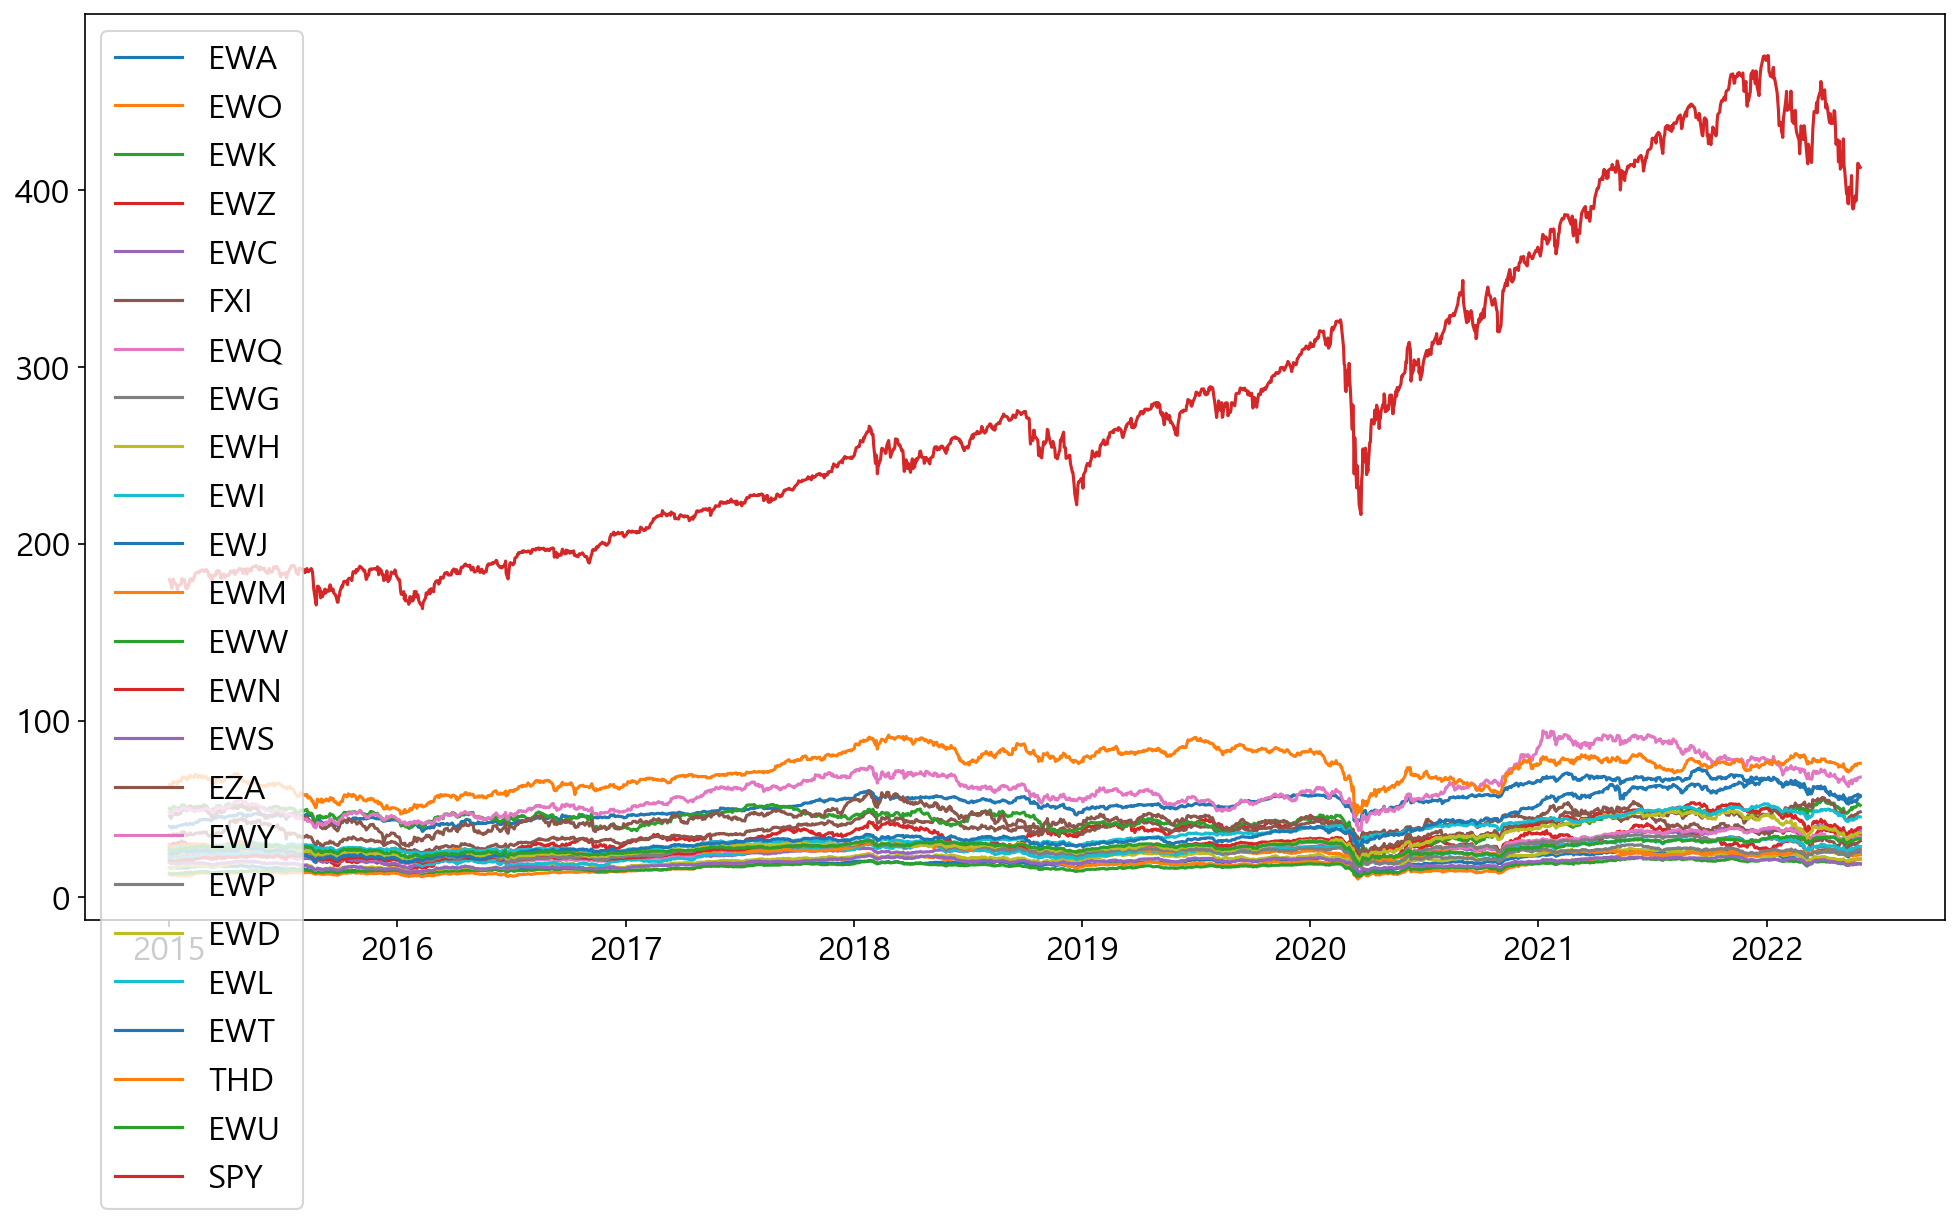

In [57]:
# 종가만 모아보자
# 데이터 시각화
stocks = dict()
legend = []

for ticker in tickers:
    price = get_price_from_morningstar(ticker)
    stocks[ticker] = price['Close'].values[:].tolist()
    legend.append(ticker)

# dict -> Dataframe
prices = pd.DataFrame(stocks)
prices.head()

# index 수정
prices.index = price.index
# prices.head()

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.figure(figsize=(16,8))

plt.plot(prices)
plt.legend(legend, loc='upper left')


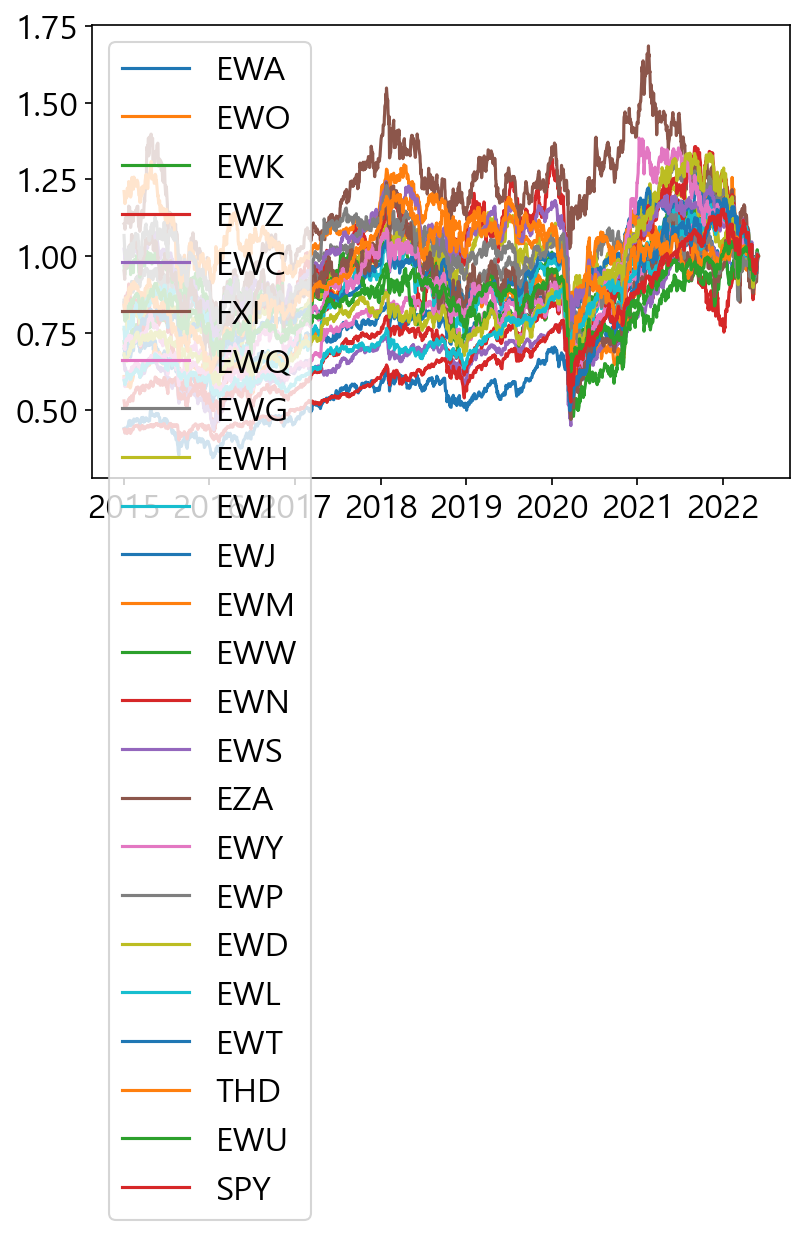

In [58]:
# 누적 수익률로 비교
plt.plot(prices/prices.iloc[0])
plt.legend(legend, loc='upper left')

In [59]:
prices.tail()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78


In [60]:
prices.sort_index().head()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20


In [61]:
prices.sort_index(inplace=True)

In [62]:
prices.head()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,16.686,13.088,13.607,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-05,16.526,12.686,13.273,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-06,16.459,12.567,13.147,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-07,16.611,12.730,13.220,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
2015-01-08,16.830,12.713,13.348,30.670,24.049,35.857,20.271,23.116,16.864,21.284,...,19.474,47.941,48.845,26.287,24.343,27.008,25.085,65.544,26.836,180.20


In [63]:
prices.tail()

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-24,24.32,21.21,18.8183,34.78,36.47,29.19,33.32,26.51,21.50,28.26,...,18.70,46.46,66.12,25.91,35.96,44.96,54.05,75.06,32.77,393.89
2022-05-25,24.40,21.40,18.7600,34.75,36.65,29.56,33.30,26.49,21.53,28.47,...,18.69,45.60,66.00,26.10,35.32,44.61,54.68,74.66,32.94,397.37
2022-05-26,24.43,21.50,18.9100,35.50,37.03,30.72,33.95,26.97,21.74,28.86,...,19.03,46.95,66.56,26.40,35.82,45.16,54.91,75.46,33.05,405.31
2022-05-27,24.95,21.55,19.0200,35.72,37.62,30.94,34.55,27.36,22.13,28.97,...,19.22,47.89,67.60,26.53,36.55,45.77,56.04,75.73,33.21,415.26
2022-05-31,24.68,21.54,18.8615,35.25,37.83,31.86,34.30,27.33,22.17,28.83,...,19.08,48.37,68.04,26.25,36.50,45.55,57.06,75.86,33.17,412.93


In [64]:
prices.shift(1)

,EWA,EWO,EWK,EWZ,EWC,FXI,EWQ,EWG,EWH,EWI,...,EWS,EZA,EWY,EWP,EWD,EWL,EWT,THD,EWU,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,16.686,13.088,13.6070,29.900,24.749,35.214,20.677,23.408,16.864,22.143,...,19.520,46.035,48.089,28.017,24.887,27.104,25.002,63.714,27.126,179.78
2015-01-06,16.526,12.686,13.2730,28.875,24.082,35.086,19.933,22.592,16.741,21.022,...,19.099,44.717,47.491,26.847,24.205,26.743,24.684,61.942,26.442,176.53
2015-01-07,16.459,12.567,13.1470,29.391,23.729,34.656,19.714,22.497,16.487,20.796,...,18.875,45.760,47.316,26.398,24.025,26.459,24.184,62.334,26.139,174.88
2015-01-08,16.611,12.730,13.2200,30.188,23.754,35.568,19.909,22.686,16.800,21.005,...,19.085,47.129,47.912,26.638,24.245,26.631,24.600,64.637,26.366,177.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,24.350,21.020,18.8800,34.840,36.840,30.350,33.430,26.690,21.780,28.200,...,19.000,46.890,67.130,25.570,35.760,44.520,54.920,75.370,32.710,396.92
2022-05-25,24.320,21.210,18.8183,34.780,36.470,29.190,33.320,26.510,21.500,28.260,...,18.700,46.460,66.120,25.910,35.960,44.960,54.050,75.060,32.770,393.89
2022-05-26,24.400,21.400,18.7600,34.750,36.650,29.560,33.300,26.490,21.530,28.470,...,18.690,45.600,66.000,26.100,35.320,44.610,54.680,74.660,32.940,397.37


In [65]:
history_prices = prices.shift(1)

In [66]:
import itertools as it

cash = 100000
period = 120
max_traded_pairs = 5 # the top 5 pairs with the smallest distance are used.
total_portfolio_value = cash
jango_value = 0
jango = []

traded_pairs = []
traded_quantity = {}

sorted_pairs = []
symbol_pairs = list(it.combinations(tickers, 2))

In [67]:
index = period + 1
# while index <= prices.shape[0]:
history_prices = prices.shift(1)[index - period : index]

In [68]:
# history_price를 만들어서 그걸 업데이트하고 -> 완료
# 다른건 history_price를 바라보게 하면 편할까?

pairs_to_remove = []

def Distance(price_a, price_b):
    # Calculate the sum of squared deviations between two normalized price series
    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]
    return sum((norm_a - norm_b)**2)

In [69]:
distances = {}
for pair in symbol_pairs:
    distances[pair] = Distance(history_prices[pair[0]], history_prices[pair[1]])

if len(distances) != 0:
    sorted_pairs = sorted(distances.items(), key=lambda x: x[1])[:max_traded_pairs]

In [70]:
sorted_pairs

[(('EWQ', 'EWN'), 0.020393478043192314),
 (('EWQ', 'EWL'), 0.03130393765645377),
 (('EWQ', 'EWD'), 0.035057952416993485),
 (('EWK', 'EWQ'), 0.03796136575880737),
 (('EWN', 'EWL'), 0.039116285845667335)]

In [73]:
sorted_pairs[0][0]

('EWQ', 'EWN')

In [83]:
days = 20
if days == 20:
    # pair 재세팅
    # minimize the sum of squared deviations
    distances = {}
    for pair in symbol_pairs:
        distances[pair] = Distance(history_prices[pair[0]], history_prices[pair[1]])
    
    if len(distances) != 0:
        sorted_pairs = sorted(distances.items(), key= lambda x: x[1])[:max_traded_pairs]
        
    # 포지션 청산
    traded_pairs.clear()
    traded_quantity.clear()
    # 잔고/예수금 반영 필요

    days = 0
    pairs_to_remove = []
    traded_pairs = []
    traded_quantity = {}

days += 1
index += 1

history_prices = prices.shift(1)[index - period + 1 : index + 1]


# pair 1개당 거래금액 = 예수금 / 최대 거래가능한 pair / 2
traded_portfolio_value = cash / max_traded_pairs / 2



for raw_pair in sorted_pairs:
    pair = raw_pair[0]
    # spread 계산
    price_a = history_prices[pair[0]]
    price_b = history_prices[pair[1]]

    norm_a = np.array(price_a) / price_a[0]
    norm_b = np.array(price_b) / price_b[0]

    spread = norm_a - norm_b
    mean = np.mean(spread)
    std = np.std(spread)
    actural_spread = spread[-1]

    # Long-short positon is open when pair prices have diverged by twe standard deviations.
    if actural_spread > mean + 0.5*std or actural_spread < mean - 0.5*std:
        # 조건1) 거래한 pair 리스트에 없다면 거래 시작 
        if pair not in traded_pairs:
            # 조건2) 거래할 수 있는 pair 자리가 있다면 거래 시작
            if len(traded_pairs) < max_traded_pairs:
                symbol_a = pair[0]
                symbol_b = pair[1]
                a_price = price_a[-1] # 전일 종가
                b_price = price_b[-1] # 전일 종가
                a_price_norm = norm_a[-1]
                b_price_norm = norm_b[-1]

            # price_a > price_b
            if a_price_norm > b_price_norm:
                long_q = int(traded_portfolio_value / b_price) # long b etf
                short_q = int(traded_portfolio_value / a_price) # short a etf
                
                prices[symbol_a]

                traded_pairs.append(pair)
                traded_quantity[pair] = (long_q, short_q)

In [75]:
pair[0]

'EWN'

In [84]:
history_prices[pair[0]][-1]

50.038

In [85]:
prices[pair[0]].iloc[index-1]

50.038

In [82]:
history_prices[pair[0]]

Date
2015-01-07    19.948
2015-01-08    20.122
2015-01-09    20.432
2015-01-12    20.212
2015-01-13    20.342
               ...  
2015-06-23    23.883
2015-06-24    23.781
2015-06-25    23.578
2015-06-26    23.651
2015-06-29    23.768
Name: EWN, Length: 120, dtype: float64

In [ ]:
sorted_pairs

[('EWA', 'EWC'),
 ('EWO', 'EWC'),
 ('EWK', 'EWC'),
 ('EWZ', 'EWC'),
 ('EWA', 'EWD')]

In [ ]:
Distance(history_prices[pair[0]], history_prices[pair[1]])

nan

In [ ]:
history_prices[pair[0]]

Date
2015-01-02       NaN
2015-01-05    16.686
2015-01-06    16.526
2015-01-07    16.459
2015-01-08    16.611
               ...  
2022-05-23    24.040
2022-05-24    24.350
2022-05-25    24.320
2022-05-26    24.400
2022-05-27    24.430
Name: EWA, Length: 1865, dtype: float64

In [ ]:
class account:
    def __init__(self, cash, taxrate=0.00315):
        self.cash = cash
        self.jango = {}
        self.taxrate = taxrate
    
    def buyorder(self, symbol_q, long_q):
        if prices[symbol_q].values[-1] * long_q <= self.cash:
            self.cash -= prices[symbol_q].values[-1] * long_q
            self.jango[symbol_q] += long_q

    def sellorder(self, symbol_q, long_q):






1

잔고, 예수금, 평가금액을 어떻게 관리해야할까?